In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import geopandas as gpd

/home/caprice/micromamba/envs/summerfog/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


files = sorted(glob.glob("*.nc"))
files

In [2]:

fn = "/mnt/c/Users/isabe/FILES/Documents/FHL Summer 2025/2022-09-29T19_01_47.715049000.nc"



In [3]:
ds = xr.open_dataset(fn)

ds

In [4]:
ds


<xarray.Dataset> Size: 78MB
Dimensions:              (y: 2335, x: 1678)
Coordinates:
  * y                    (y) float64 19kB 5.42e+06 5.42e+06 ... 5.35e+06
  * x                    (x) float64 13kB 4.75e+05 4.75e+05 ... 5.253e+05
    time                 datetime64[ns] 8B ...
Data variables:
    spatial_ref          int32 4B ...
    nir08                (y, x) uint16 8MB ...
    red                  (y, x) uint16 8MB ...
    green                (y, x) uint16 8MB ...
    blue                 (y, x) uint16 8MB ...
    qa_pixel             (y, x) uint16 8MB ...
    lwir11               (y, x) uint16 8MB ...
    temperature_celsius  (y, x) float64 31MB ...

(48.465113, -122.952554)

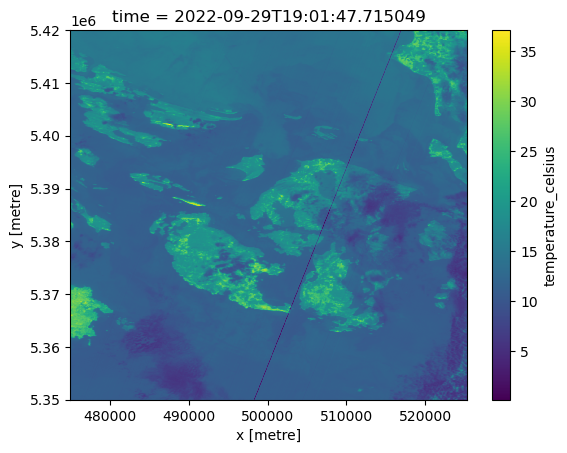

In [ ]:
ds['temperature_celsius'].plot()

#can plot any of variables listed above 
48.465113, -122.952554





In [ ]:
#this code converts from latlong
#got this point from google maps off of CP, had to convert from latlong (WGS84) (world geodetic system 1984) into UTM 10-N
#important to note: latlong is EPSG:4326, UTM is EPSG:32610
#UTM 10N is specifically western washington + a little more
from shapely.geometry import Point
#Point has functions like buffer, etc, which we used to make circle
#shapely is vector data
import geopandas as gpd 

# Define the lat/lon point
lat_lon_point = Point(-122.952554, 48.465113)

# Create a GeoDataFrame with the point and its original CRS (EPSG:4326)
gdf = gpd.GeoDataFrame(geometry=[lat_lon_point], crs="EPSG:4326")
#geopandas is able to convert btwn coords pretty easily, so made a GeoDataFrame for that reason only - csv with 1 item in it, essentially

# Reproject the GeoDataFrame to the target CRS (EPSG:32610)
gdf_reprojected = gdf.to_crs("EPSG:32610")
#coordinate reference system

# Extract the reprojected point
reprojected_point = gdf_reprojected.geometry[0]
print(reprojected_point)

POINT (503507.328175198 5367998.7916395)


In [11]:
reprojected_point.x

503507.328175198

In [ ]:
#extracting data from a single point
#
ds.interp(x=reprojected_point.x, y=reprojected_point.y, method='nearest') #nearest vs linear = method used to get values at point from gridded data set

<xarray.Dataset> Size: 84B
Dimensions:              ()
Coordinates:
    time                 datetime64[ns] 8B ...
    x                    float64 8B 5.035e+05
    y                    float64 8B 5.368e+06
Data variables:
    spatial_ref          int32 4B ...
    nir08                float64 8B 7.117e+03
    red                  float64 8B 7.125e+03
    green                float64 8B 7.617e+03
    blue                 float64 8B 7.5e+03
    qa_pixel             float64 8B 2.195e+04
    lwir11               float64 8B 3.956e+04
    temperature_celsius  float64 8B 11.08

In [26]:
ds

<xarray.Dataset> Size: 78MB
Dimensions:              (y: 2335, x: 1678)
Coordinates:
  * y                    (y) float64 19kB 5.42e+06 5.42e+06 ... 5.35e+06
  * x                    (x) float64 13kB 4.75e+05 4.75e+05 ... 5.253e+05
    time                 datetime64[ns] 8B ...
Data variables:
    spatial_ref          int32 4B ...
    nir08                (y, x) uint16 8MB ...
    red                  (y, x) uint16 8MB ...
    green                (y, x) uint16 8MB ...
    blue                 (y, x) uint16 8MB ...
    qa_pixel             (y, x) uint16 8MB ...
    lwir11               (y, x) uint16 8MB ...
    temperature_celsius  (y, x) float64 31MB ...

<Axes: title={'center': 'time = 2022-09-29T19:01:47.715049, spatial_ref = 0'}, xlabel='x [metre]', ylabel='y [metre]'>

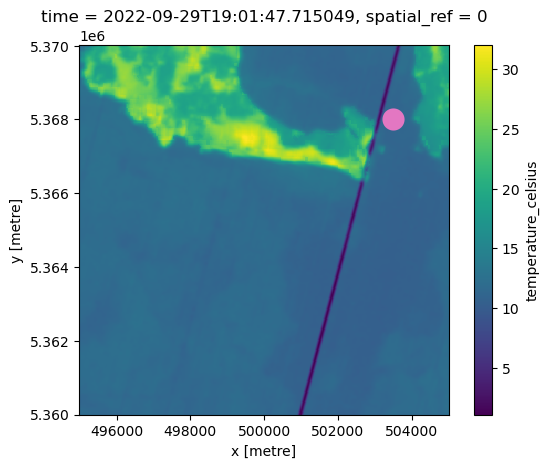

In [ ]:
#extracting data for an area
#using a buffer function 
#.buffer() makes a polygon
#again, using GeoDataFrame as a convenient way to do things - table w/ one item in it
gdf = gpd.GeoDataFrame(
    geometry=[reprojected_point.buffer(300)], 
    crs="EPSG:32610"
)


fig, ax = plt.subplots()
ds['temperature_celsius'].loc[5.37e6:5.36e6, 4.95e5:5.05e5].plot(ax = ax)
#plt.ylim(5.36e6, 5.37e6)

gdf.plot(ax = ax, color='tab:pink')
#using gdf to plot

In [47]:
ds

<xarray.Dataset> Size: 78MB
Dimensions:              (y: 2335, x: 1678)
Coordinates:
  * y                    (y) float64 19kB 5.42e+06 5.42e+06 ... 5.35e+06
  * x                    (x) float64 13kB 4.75e+05 4.75e+05 ... 5.253e+05
    time                 datetime64[ns] 8B ...
    spatial_ref          int64 8B 0
Data variables:
    nir08                (y, x) uint16 8MB ...
    red                  (y, x) uint16 8MB ...
    green                (y, x) uint16 8MB ...
    blue                 (y, x) uint16 8MB ...
    qa_pixel             (y, x) uint16 8MB ...
    lwir11               (y, x) uint16 8MB ...
    temperature_celsius  (y, x) float64 31MB ...

In [ ]:
ds = ds.rio.write_crs('EPSG:32610')
#in order to use rio.clip, needed to make sure that ds had "i am in UTM coords" written in the right place
#so write_crs does that for us


In [ ]:
dsclipped = ds.rio.clip(gdf.geometry, all_touched=True)
#clipping all data to just the circle and getting what's inside
#getting rid of all_touched=True makes it default False

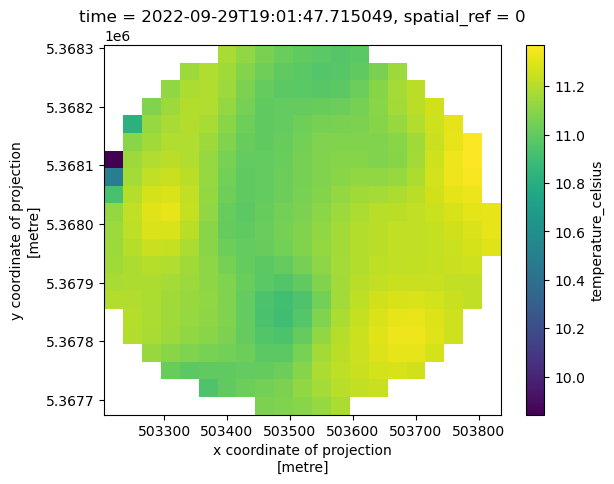

In [ ]:
dsclipped['temperature_celsius'].plot()
#plotting!

In [52]:
dsclipped.mean(dim=["x", "y"])

<xarray.Dataset> Size: 72B
Dimensions:              ()
Coordinates:
    time                 datetime64[ns] 8B ...
    spatial_ref          int64 8B 0
Data variables:
    nir08                float64 8B 5.672e+03
    red                  float64 8B 5.684e+03
    green                float64 8B 6.066e+03
    blue                 float64 8B 5.957e+03
    qa_pixel             float64 8B 1.747e+04
    lwir11               float64 8B 3.15e+04
    temperature_celsius  float64 8B 11.13

In [38]:
dsclipped

<xarray.Dataset> Size: 960B
Dimensions:              (y: 7, x: 6)
Coordinates:
  * y                    (y) float64 56B 5.368e+06 5.368e+06 ... 5.368e+06
  * x                    (x) float64 48B 5.034e+05 5.035e+05 ... 5.036e+05
    time                 datetime64[ns] 8B ...
    spatial_ref          int64 8B 0
Data variables:
    nir08                (y, x) uint16 84B 0 7130 7138 7143 7135 ... 0 7134 0 0
    red                  (y, x) uint16 84B 0 7130 7149 7148 7139 ... 0 7143 0 0
    green                (y, x) uint16 84B 0 7648 7650 7632 7625 ... 0 7625 0 0
    blue                 (y, x) uint16 84B 0 7500 7513 7517 7510 ... 0 7494 0 0
    qa_pixel             (y, x) uint16 84B 1 21952 21952 21952 ... 1 21952 1 1
    lwir11               (y, x) uint16 84B 0 39541 39549 39556 ... 0 39539 0 0
    temperature_celsius  (y, x) float64 336B nan 11.0 11.03 ... 11.0 nan nan